<a href="https://colab.research.google.com/github/karjain/Anti_deepFake/blob/main/Data_cleaning_Model_K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Generic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime as dt
from math import sqrt, isnan, pi, sin, cos, atan2
import requests
import gzip
from functools import reduce
import scipy as scp
import seaborn as sns
import scipy.interpolate

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score


import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

In [4]:
def get_NOAA_data():
    
    URL = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
    r = requests.get(URL)
    file_names = pd.read_html(r.text)[0]['Name']
    events_file_names = file_names[file_names.str.contains("details",na=False)]
    noaa_list = []
    
    print("Extracting CSV files...")
    for file in events_file_names:
        full_URL = URL + file
        with gzip.open(requests.get(full_URL, stream=True).raw) as f:
            noaa_list.append(pd.read_csv(f))
        
    df = pd.concat(noaa_list)
    
    print("Completed")
    return df

def pickle_source_data():
    noaa_source_df = get_NOAA_data()
    home_dir = os.getcwd()
    data_dir = os.path.join(home_dir, "Data")
    try:
        os.mkdir(data_dir)
        os.chdir(data_dir)
    except OSError:
        os.chdir(data_dir)
        for file in os.listdir():
            os.remove(file)
    noaa_source_df.to_pickle('noaa_source_data.pkl')
    os.chdir(home_dir)
    return noaa_source_df

NOAA_df = pickle_source_data()
    

Extracting CSV files...
Completed


In [ ]:
NOAA_df = pd.read_pickle('/content/drive/MyDrive/noaa_source_data.pkl')

In [5]:
def replace_str2num(x):
    if type(x) == float or type(x) == int:
        return float(x)
    num = 1 if x[:-1] == '' else x[:-1]        
    if x[-1] == 'T':
        return float(num) * 1000000000000
    elif x[-1] == 'B':
        return float(num) * 1000000000
    elif x[-1] == 'M':
        return float(num) * 1000000
    elif x[-1] == 'K' or x[-1] == 'k':
        return float(num) * 1000
    elif x[-1] == 'h' or x[-1] == 'H':
        return float(num) * 100
    elif x[-1] == '?':
        return float(num)
    else:
        return float(x)

def winds(x):
    if x['MAGNITUDE_TYPE'] in ['EG', 'E', 'M', 'ES', 'MG', 'MS']:
        return x['MAGNITUDE']

def hail(x):
    if x['MAGNITUDE_TYPE'] not in ['EG', 'E', 'M', 'ES', 'MG', 'MS']:
        return x['MAGNITUDE']

def missing_swap(df, col1, col2):
    df.loc[~df[col1].isnull() & df[col2].isnull(), col2] = df.loc[~df[col1].isnull() & df[col2].isnull(), col1]
    df.loc[df[col1].isnull() & ~df[col2].isnull(), col1] = df.loc[df[col1].isnull() & ~df[col2].isnull(), col2]
    return df

In [ ]:
# Using data after Year 2005 and checking how many columns have NULL values

NOAA_df = NOAA_df[NOAA_df['YEAR']> 2005]

for i in NOAA_df.columns:
    if NOAA_df[i].isna().sum() > 0:
        print(NOAA_df[i].name, ":", NOAA_df[i].isna().sum(), "\n")
        print((NOAA_df[i].isna().sum()/NOAA_df.shape[0])*100, "\n")
    else:
        continue

In [6]:
# calculating distance w.r.t Latitude and Longitude

def geo_distance(x):
    # Source : https://en.wikipedia.org/wiki/Haversine_formula
    p = pi/180
    lat1 = x['BEGIN_LAT']
    lat2 = x['END_LAT']
    lon1 = x['BEGIN_LON']
    lon2 = x['END_LON']
    R = 6371
    dLat = p * (lat2-lat1)
    dLon = p * (lon2-lon1)
    a = sin(dLat/2) * 2 + cos(p*lat1) * cos(p*lat2) * sin(dLon/2) * 2
    if a < 0 :
      return a
    else:
      return 2 * R * atan2(sqrt(a), sqrt(1-a))

NOAA_df['GEO_DISTANCE'] = NOAA_df.apply(lambda x: geo_distance(x), axis=1)

In [7]:
# NOAA_df['DURATION_OF_STORM'] = (pd.to_datetime(NOAA_df['END_DATE_TIME']) - pd.to_datetime(NOAA_df['BEGIN_DATE_TIME']))
# NOAA_df['DURATION_OF_STORM'] = NOAA_df['DURATION_OF_STORM'].astype('str').str[:-13]

# calculate duration of the storm event

def calc_duration(x):
    begin_dt = dt.strptime(x['BEGIN_DATE_TIME'], "%d-%b-%y %H:%M:%S")
    end_dt = dt.strptime(x['END_DATE_TIME'], "%d-%b-%y %H:%M:%S")
    difference = end_dt - begin_dt
    difference_days = difference.days + difference.seconds/86400
    return difference_days

NOAA_df['DURATION_OF_STORM'] = NOAA_df.apply(lambda x: calc_duration(x), axis=1)

In [8]:
# Damage variables cleaning

NOAA_df['DAMAGE_PROPERTY'] = NOAA_df.DAMAGE_PROPERTY.map(replace_str2num)

NOAA_df['DAMAGE_CROPS'] = NOAA_df.DAMAGE_CROPS.map(replace_str2num)

# Removing inconsistencies
NOAA_df = missing_swap(NOAA_df, 'BEGIN_RANGE', 'END_RANGE')
NOAA_df = missing_swap(NOAA_df, 'BEGIN_LAT', 'END_LAT')
NOAA_df = missing_swap(NOAA_df, 'BEGIN_LON', 'END_LON')
NOAA_df = missing_swap(NOAA_df, 'BEGIN_AZIMUTH', 'END_AZIMUTH')
NOAA_df = missing_swap(NOAA_df, 'BEGIN_LOCATION', 'END_LOCATION')

In [9]:
# impute DAMAGE_PROPERTY and DAMAGE_CROPS with mean value of damage per EVENT_TYPE

X = NOAA_df.groupby('EVENT_TYPE')

Y = X['DAMAGE_CROPS'].mean()

reset_index = Y.reset_index()

Y1 = X['DAMAGE_PROPERTY'].mean()

reset_index1 = Y1.reset_index()

NOAA_df = pd.merge(NOAA_df, reset_index, on='EVENT_TYPE', how='inner')

NOAA_df = pd.merge(NOAA_df, reset_index1, on='EVENT_TYPE', how='inner')

NOAA_df.drop(columns=['DAMAGE_CROPS_x','DAMAGE_PROPERTY_x'], inplace=True)

NOAA_df = NOAA_df.rename(columns={"DAMAGE_CROPS_y": "DAMAGE_CROPS", "DAMAGE_PROPERTY_y":"DAMAGE_PROPERTY"})


In [10]:
def impute_NOAA_data(df):
    
    # magnitude converted into other variables
    drop_list = ['EVENT_NARRATIVE', 'EPISODE_NARRATIVE', 'EPISODE_ID', 'MAGNITUDE', 'BEGIN_LAT', 'END_LAT', 'BEGIN_LON', 'END_LON','BEGIN_DATE_TIME','END_DATE_TIME','STATE_FIPS', 'TOR_OTHER_CZ_FIPS', 'WFO', 'SOURCE'
               , 'CATEGORY', 'DATA_SOURCE', 'TOR_OTHER_WFO']
    #  impute_mean_list = ['BEGIN_LAT', 'END_LAT', 'BEGIN_LON', 'END_LON'] # removed because for events like DROUGHT there should be no travelled distance and added to drop list
    # Instead impute GEO_DISTANCE to 0
    
    # imputing damage columns with 0 for the time-being
    impute_zero_list = ['BEGIN_RANGE', 'END_RANGE', 'WIND_SPEED', 'HAIL_SIZE','GEO_DISTANCE']
    impute_NA_list = ['CZ_NAME', 'STATE', 'MAGNITUDE_TYPE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LOCATION', 'END_LOCATION', 'FLOOD_CAUSE', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH','TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_NAME']
      
    # Splitting magnitude variable into constituent attributes
    df['WIND_SPEED'] = df.apply(winds, axis = 1)
    df['HAIL_SIZE'] = df.apply(hail, axis = 1)
    
    # Imputing string columns with missing values with NA
    for col in impute_NA_list:
        df[col] = df[col].astype('str').apply(lambda x: 'NA' if x=='nan' else x) # changed from N/A to NA
        
    # Imputing float columns having missing values with 0.0
    for col in impute_zero_list:
        df[col] = df[col].fillna(0.0)
        
    # Imputing latitude and longitudes with average value
    # for col in impute_mean_list:
    #     df[col] = df[col].fillna(np.mean)
        
    # Dropping text and ID columns
    for col in drop_list:
        df.drop(col, axis=1, inplace=True)
    
    return df

# NOAA_df.dropna(subset=["DAMAGE_PROPERTY"], inplace=True)
# NOAA_df.dropna(subset=["DAMAGE_CROPS"], inplace=True)

imputed_NOAA_df = impute_NOAA_data(NOAA_df.copy())
imputed_NOAA_df.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EVENT_ID,STATE,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,CZ_TIMEZONE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,MAGNITUDE_TYPE,FLOOD_CAUSE,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,GEO_DISTANCE,DURATION_OF_STORM,DAMAGE_CROPS,DAMAGE_PROPERTY,WIND_SPEED,HAIL_SIZE
0,195004,28,1445,195004,28,1445,10096222,OKLAHOMA,1950,April,Tornado,C,149,WASHITA,CST,0,0,0,0,NA,NA,F3,3.4,400.0,NA,NA,0.0,NA,NA,0.0,NA,NA,376.464878,0.0,8624.561746,1.100533e+06,0.0,0.0
1,195004,29,1530,195004,29,1530,10120412,TEXAS,1950,April,Tornado,C,93,COMANCHE,CST,0,0,0,0,NA,NA,F1,11.5,200.0,NA,NA,0.0,NA,NA,0.0,NA,NA,-0.002967,0.0,8624.561746,1.100533e+06,0.0,0.0
2,195007,5,1800,195007,5,1800,10104927,PENNSYLVANIA,1950,July,Tornado,C,77,LEHIGH,CST,2,0,0,0,NA,NA,F2,12.9,33.0,NA,NA,0.0,NA,NA,0.0,NA,NA,758.020781,0.0,8624.561746,1.100533e+06,0.0,0.0
3,195007,5,1830,195007,5,1830,10104928,PENNSYLVANIA,1950,July,Tornado,C,43,DAUPHIN,CST,0,0,0,0,NA,NA,F2,0.0,13.0,NA,NA,0.0,NA,NA,0.0,NA,NA,0.000000,0.0,8624.561746,1.100533e+06,0.0,0.0
4,195007,24,1440,195007,24,1440,10104929,PENNSYLVANIA,1950,July,Tornado,C,39,CRAWFORD,CST,0,0,0,0,NA,NA,F0,0.0,33.0,NA,NA,0.0,NA,NA,0.0,NA,NA,0.000000,0.0,8624.561746,1.100533e+06,0.0,0.0


In [ ]:
def get_EPA_data():
    
    ground_temp_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/temperature_fig-1.csv', skiprows=6, usecols = [0, 1], encoding='latin1')
    ground_temp_df.columns = ["YEAR", "SURFACE_TEMP_DIFF"]
    
    greenhouse_df = pd.read_csv("https://www.epa.gov/sites/default/files/2021-04/us-ghg-emissions_fig-1.csv",skiprows=6)
    greenhouse_df.columns = ["YEAR", "CO2", "METHANE", "N2O", "HFC_PFC_SF6_NF3"]
    
    precipitation_df =  pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/heavy-precip_fig-1.csv',skiprows=6)
    precipitation_df.columns = ["YEAR", "PPT_LAND_AREA", "PPT_NINE_YEAR_AVG"]
    
    sea_level_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/sea-level_fig-1.csv', skiprows=6)
    sea_level_df.columns = ["YEAR", "CSIRO_ADJ_SEA_LEVEL", "CSIRO_LOWER", "CSIRO_UPPER", "NOAA_ADJ_SEA_LEVEL"]
    sea_level_df.loc[sea_level_df['YEAR'] > 1992, 'CSIRO_ADJ_SEA_LEVEL'] = sea_level_df.loc[sea_level_df['YEAR'] > 1992, 'NOAA_ADJ_SEA_LEVEL']
    sea_level_df.drop(['CSIRO_LOWER', 'CSIRO_UPPER', 'NOAA_ADJ_SEA_LEVEL'], axis=1, inplace=True)
    
    seasonal_temp_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/seasonal-temperature_fig-1.csv', skiprows=6)
    seasonal_temp_df.columns = ["YEAR", "WINTER_ANOMALY", "SPRING_ANOMALY", "SUMMER_ANOMALY", "FALL_ANOMALY"]
    
    arctic_ice_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-03/arctic-sea-ice_fig-1.csv', skiprows=6)
    arctic_ice_df.columns = ["YEAR", "ICE_CVG_MARCH", "ICE_CVG_SEP"]
    
    glacier_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-03/glaciers_fig-1.csv', skiprows=6)
    glacier_df.columns = ["YEAR", "GLACIER_MASS_BAL", "NUM_OBS"]
    glacier_df.drop(['NUM_OBS'], axis=1, inplace=True)
    
    dfs = [ground_temp_df, greenhouse_df, precipitation_df, sea_level_df, seasonal_temp_df, arctic_ice_df, glacier_df]
    epa_df = reduce(lambda left, right: pd.merge(left, right, how="outer", on="YEAR"), dfs)
    epa_df = epa_df[epa_df.YEAR >= 1950]
    
    return epa_df

epa_source_df = get_EPA_data()

In [ ]:
def impute_EPA_DATA(df, breaks):
    fillable_cols = df.columns[df.isnull().sum() > 0]
    for col in fillable_cols:
        temp_df = df[['YEAR', col]]
        present_df = temp_df[~ temp_df[col].isnull()]
        null_df = temp_df[temp_df[col].isnull()]
        years = sorted(np.random.choice(present_df['YEAR'], breaks))
        input_df = present_df[present_df['YEAR'].isin(years)]
        func = scipy.interpolate.interp1d(input_df['YEAR'], input_df[col], fill_value="extrapolate")
        temp_df['INTERPOLATION'] = func(temp_df['YEAR'])
        df[col] = temp_df.apply(lambda x: x['INTERPOLATION'] if isnan(x[col]) else x[col], axis=1)
    return df
        
imputed_EPA_df = impute_EPA_DATA(epa_source_df.copy(), 6)
imputed_EPA_df.head()

In [11]:
#cleaned_df = pd.merge(imputed_NOAA_df, imputed_EPA_df, on='YEAR', how='inner')
cleaned_df = imputed_NOAA_df
cleaned_df.to_pickle('/content/drive/MyDrive/cleaned.pkl')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

cleaned_df = pd.read_pickle('/content/drive/MyDrive/cleaned.pkl')

cleaned_df = cleaned_df[cleaned_df['YEAR'] >= 2005]

In [ ]:
cleaned_df.head()

In [3]:
#Filtering to get the events with damage greater than 100000
drop_event = {}
df_temp = cleaned_df.groupby('EVENT_TYPE')['DAMAGE_PROPERTY'].mean()
df_temp = df_temp[df_temp>100000]
big_event = df_temp.index.to_list()
cleaned_df = cleaned_df[cleaned_df['EVENT_TYPE'].isin(big_event)]

In [4]:
df_onhot = pd.get_dummies(cleaned_df, columns=['MONTH_NAME','EVENT_TYPE','CZ_TYPE','FLOOD_CAUSE','BEGIN_AZIMUTH'])
features = ['DAMAGE_PROPERTY','MONTH_NAME','EVENT_TYPE','CZ_TYPE','FLOOD_CAUSE','BEGIN_AZIMUTH','INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT','MAGNITUDE_TYPE','TOR_F_SCALE','TOR_WIDTH','GEO_DISTANCE','DURATION_OF_STORM','DAMAGE_CROPS','WIND_SPEED','HAIL_SIZE']
cleaned_df = cleaned_df[features]
cleaned_df = pd.get_dummies(cleaned_df, columns=['MONTH_NAME','EVENT_TYPE','CZ_TYPE','FLOOD_CAUSE','BEGIN_AZIMUTH','TOR_F_SCALE','MAGNITUDE_TYPE'])
cleaned_df.head()

,DAMAGE_PROPERTY,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,TOR_WIDTH,GEO_DISTANCE,DURATION_OF_STORM,DAMAGE_CROPS,WIND_SPEED,HAIL_SIZE,MONTH_NAME_April,MONTH_NAME_August,MONTH_NAME_December,MONTH_NAME_February,MONTH_NAME_January,MONTH_NAME_July,MONTH_NAME_June,MONTH_NAME_March,MONTH_NAME_May,MONTH_NAME_November,MONTH_NAME_October,MONTH_NAME_September,EVENT_TYPE_Blizzard,EVENT_TYPE_Coastal Flood,EVENT_TYPE_Debris Flow,EVENT_TYPE_Flash Flood,EVENT_TYPE_Flood,EVENT_TYPE_Hail,EVENT_TYPE_High Wind,EVENT_TYPE_Hurricane,EVENT_TYPE_Hurricane (Typhoon),EVENT_TYPE_Ice Storm,EVENT_TYPE_Lake-Effect Snow,EVENT_TYPE_Lakeshore Flood,EVENT_TYPE_Landslide,EVENT_TYPE_Storm Surge/Tide,EVENT_TYPE_Tornado,EVENT_TYPE_Tropical Depression,EVENT_TYPE_Tropical Storm,...,FLOOD_CAUSE_Heavy Rain / Snow Melt,FLOOD_CAUSE_Heavy Rain / Tropical System,FLOOD_CAUSE_Ice Jam,FLOOD_CAUSE_NA,FLOOD_CAUSE_Planned Dam Release,BEGIN_AZIMUTH_E,BEGIN_AZIMUTH_ENE,BEGIN_AZIMUTH_ESE,BEGIN_AZIMUTH_N,BEGIN_AZIMUTH_NA,BEGIN_AZIMUTH_NE,BEGIN_AZIMUTH_NNE,BEGIN_AZIMUTH_NNW,BEGIN_AZIMUTH_NW,BEGIN_AZIMUTH_S,BEGIN_AZIMUTH_SE,BEGIN_AZIMUTH_SSE,BEGIN_AZIMUTH_SSW,BEGIN_AZIMUTH_SW,BEGIN_AZIMUTH_W,BEGIN_AZIMUTH_WNW,BEGIN_AZIMUTH_WSW,TOR_F_SCALE_EF0,TOR_F_SCALE_EF1,TOR_F_SCALE_EF2,TOR_F_SCALE_EF3,TOR_F_SCALE_EF4,TOR_F_SCALE_EF5,TOR_F_SCALE_EFU,TOR_F_SCALE_F0,TOR_F_SCALE_F1,TOR_F_SCALE_F2,TOR_F_SCALE_F3,TOR_F_SCALE_F4,TOR_F_SCALE_NA,MAGNITUDE_TYPE_EG,MAGNITUDE_TYPE_ES,MAGNITUDE_TYPE_MG,MAGNITUDE_TYPE_MS,MAGNITUDE_TYPE_NA
50075,1.100533e+06,0,0,0,0,40.0,0.000000,0.000694,8624.561746,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
50076,1.100533e+06,0,0,0,0,100.0,0.000000,0.000694,8624.561746,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
50077,1.100533e+06,0,0,0,0,440.0,923.595499,0.013889,8624.561746,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
50078,1.100533e+06,0,0,0,0,220.0,329.256661,0.001389,8624.561746,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
50079,1.100533e+06,0,0,0,0,40.0,856.154104,0.005556,8624.561746,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [5]:
cleaned_df = cleaned_df.drop(columns=['TOR_WIDTH'])

In [17]:
# rfc = XGBRegressor()

# parameters = {
#     'max_depth': range(2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05]
# }

# xgb = GridSearchCV(rfc, parameters, cv=5, scoring='accuracy')

# Create train test split
# X = cleaned_df.loc[:, ~cleaned_df.columns.isin(['DAMAGE_PROPERTY'])]
X = cleaned_df.loc[:, ~cleaned_df.columns.isin(['DAMAGE_CROP', 'DAMAGE_PROPERTY'])]
Y = cleaned_df['DAMAGE_PROPERTY']

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

from sklearn.metrics import r2_score
evals=[(X_train, 'train') , (X_test, 'valid')]
xgb = XGBRegressor( learning_rate =0.01,subsample =0.9, max_depth=10, n_estimators=500, colsample_bytree=0.9)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

# print(xgb.feature_importances_)
# ,tree_method ='hist'
# ,booster ='gblinear'
# make predictions for test data
y_pred = xgb.predict(X_test)
y_pred_score = [round(value) for value in y_pred]

MSE = mean_squared_error(y_test, y_pred)
print(MSE)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(r2)
# evals=[(dX_train, 'train') , (dX_valid, 'valid')]
# [(X_train, y_train), (X_test, y_test)]

[19:18:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.41515e+06	validation_1-rmse:6.73582e+06
[1]	validation_0-rmse:6.34881e+06	validation_1-rmse:6.66902e+06
[2]	validation_0-rmse:6.28585e+06	validation_1-rmse:6.60312e+06
[3]	validation_0-rmse:6.22369e+06	validation_1-rmse:6.53671e+06
[4]	validation_0-rmse:6.16207e+06	validation_1-rmse:6.47193e+06
[5]	validation_0-rmse:6.10045e+06	validation_1-rmse:6.40645e+06
[6]	validation_0-rmse:6.04015e+06	validation_1-rmse:6.34292e+06
[7]	validation_0-rmse:5.98029e+06	validation_1-rmse:6.27987e+06
[8]	validation_0-rmse:5.92124e+06	validation_1-rmse:6.21733e+06
[9]	validation_0-rmse:5.86278e+06	validation_1-rmse:6.15576e+06
[10]	validation_0-rmse:5.80129e+06	validation_1-rmse:6.09488e+06
[11]	validation_0-rmse:5.74367e+06	validation_1-rmse:6.03383e+06
[12]	validation_0-rmse:5.68620e+06	validation_1-rmse:5.97376e+06
[13]	validation_0-rmse:5.63015e+06	val

In [9]:
xgb.feature_importances_

AttributeError: ignored

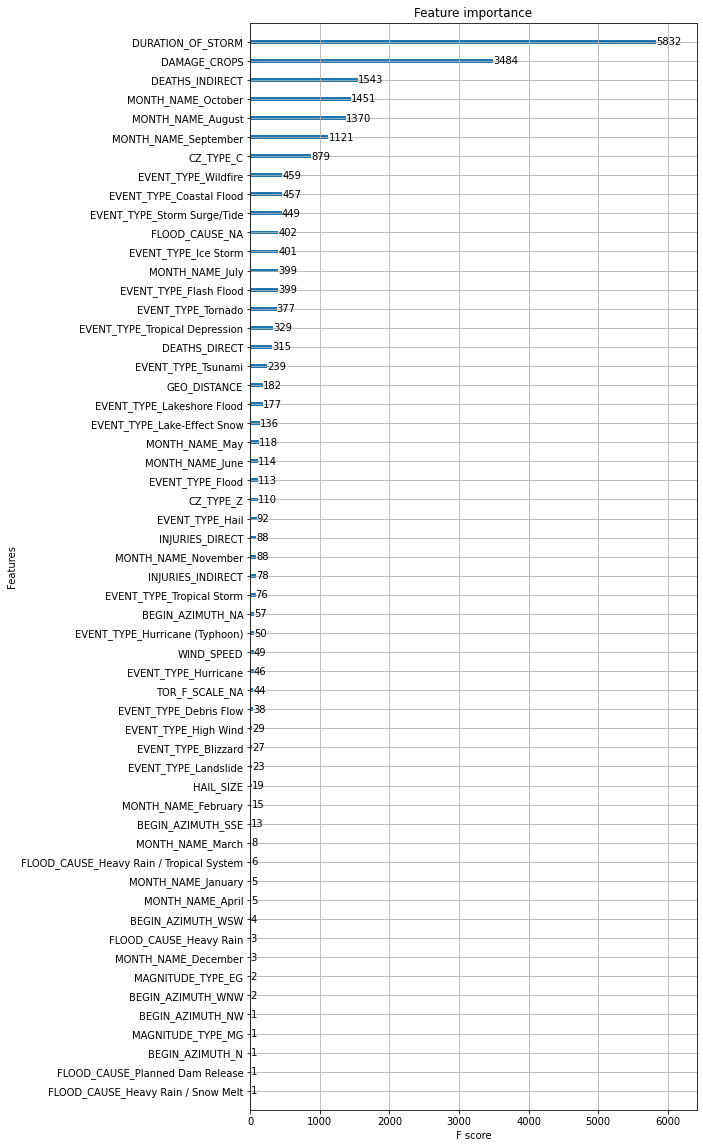

In [18]:
from xgboost import plot_importance
# from matplotlib import pyplot as plt
# plt.figure(figsize=(10,10))
plt.rcParams['figure.figsize'] = [8, 20]
plot_importance(xgb)
plt.show()

In [ ]:
# assign labels to categorical columns

def mapping(xx):
    dict = {}
    count = -1
    for x in xx:
        dict[x] = count + 1
        count = count + 1
    return dict

for i in ['STATE', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'MAGNITUDE_TYPE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'FLOOD_CAUSE', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_NAME'
          , 'CZ_NAME',  'TOR_OTHER_CZ_NAME', 'BEGIN_LOCATION', 'END_LOCATION','CZ_TIMEZONE']:
    unique_tag = df_train[i].value_counts().keys().values
    dict_mapping = mapping(unique_tag)
    df_train[i] = df_train[i].map(lambda x: dict_mapping[x] if x in dict_mapping.keys() else -1)


In [40]:
# remove any pending NAN from DAMAGE_CROPS and DAMAGE_PROPERTY

df_train.dropna(subset=["DAMAGE_PROPERTY"], inplace=True)
df_train.dropna(subset=["DAMAGE_CROPS"], inplace=True)

# check for NULL values
for i in df_train.columns:
    if df_train[i].isna().sum() > 0:
        print(df_train[i].name, ":", df_train[i].isna().sum(), "\n")
        print((df_train[i].isna().sum()/df_train.shape[0])*100, "\n")
    else:
        continue

NameError: ignored

In [ ]:
# correlation

corrmat = df_train.corr()

f, ax = plt.subplots(figsize=(22, 19))
sns.heatmap(corrmat, vmax=1.0, square=True)
plt.show()

#saleprice correlation matrix
# k = 20 #number of variables for heatmap
# cols = corrmat.nlargest(k, 'DAMAGE_PROPERTY')['DAMAGE_PROPERTY'].index
# cm = np.corrcoef(df_train[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

In [ ]:
# Create train test split
X = df_train.loc[:, ~df_train.columns.isin(['DAMAGE_PROPERTY'])]

Y = df_train['DAMAGE_PROPERTY']

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

print(X_train)

In [ ]:
# Scaling the data if required

# sc = StandardScaler()
# sc.fit(X_train)
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
# PCA code if we use one-hot encoding

# pca = PCA(.95)
# pca.fit(X_train)


# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

# print(X_train.shape)

In [59]:
model = LinearRegression()
model.fit(X_train, y_train)

print(model)

# make predictions for test data
y_pred = model.predict(X_test)
y_pred_score = [round(value) for value in y_pred]

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

print(model.score(X_train,y_train))

print(r2_score(y_test, y_pred))


LinearRegression()
2.833868772901732e-07
1.0
1.0


In [ ]:
clf_rf = RandomForestRegressor(max_depth=10, random_state=0)

# perform training
clf_rf.fit(X_train, y_train)

# make predictions

# prediction on test using all features
y_pred = clf_rf.predict(X_test)

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

print(clf_rf.score(X_train,y_train))

print(r2_score(y_test, y_pred))

41223756.15906346
0.9999974279376278
0.9999956458151047


In [ ]:
# np.argsort(clf_rf.feature_importances_)[::-1]
df_train.columns[np.argsort(xgb.feature_importances_)[::-1]]

Index(['DAMAGE_CROPS', 'EVENT_TYPE', 'INJURIES_DIRECT', 'FLOOD_CAUSE',
       'DEATHS_INDIRECT', 'TOR_WIDTH', 'TOR_LENGTH', 'TOR_F_SCALE',
       'BEGIN_AZIMUTH', 'CZ_NAME', 'END_LOCATION', 'STATE', 'MONTH_NAME',
       'BEGIN_LOCATION', 'END_TIME', 'GEO_DISTANCE', 'MAGNITUDE_TYPE',
       'CZ_TIMEZONE', 'BEGIN_DAY', 'BEGIN_YEARMONTH', 'END_AZIMUTH',
       'END_YEARMONTH', 'WIND_SPEED', 'DAMAGE_PROPERTY', 'EVENT_ID',
       'DURATION_OF_STORM', 'CZ_TYPE', 'BEGIN_TIME', 'END_DAY',
       'DEATHS_DIRECT', 'YEAR', 'CZ_FIPS', 'END_RANGE', 'BEGIN_RANGE',
       'TOR_OTHER_CZ_NAME', 'TOR_OTHER_CZ_STATE', 'INJURIES_INDIRECT'],
      dtype='object')

In [ ]:
# rfc = XGBRegressor()

# parameters = {
#     'max_depth': range(2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05]
# }

# xgb = GridSearchCV(rfc, parameters, cv=5, scoring='accuracy')


xgb = XGBRegressor(learning_rate =0.01,subsample =0.7, max_depth=5, n_estimators=100, colsample_bytree=0.8)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train)])

# print(xgb.feature_importances_)

# make predictions for test data
y_pred = xgb.predict(X_test)
y_pred_score = [round(value) for value in y_pred]

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

print(xgb.score(X_train,y_train))

print(r2_score(y_test, y_pred))

[05:26:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.02628e+06
[1]	validation_0-rmse:2.99672e+06
[2]	validation_0-rmse:2.96764e+06
[3]	validation_0-rmse:2.93756e+06
[4]	validation_0-rmse:2.90896e+06
[5]	validation_0-rmse:2.88035e+06
[6]	validation_0-rmse:2.85219e+06
[7]	validation_0-rmse:2.82347e+06
[8]	validation_0-rmse:2.79643e+06
[9]	validation_0-rmse:2.76909e+06
[10]	validation_0-rmse:2.74498e+06
[11]	validation_0-rmse:2.71832e+06
[12]	validation_0-rmse:2.69172e+06
[13]	validation_0-rmse:2.66524e+06
[14]	validation_0-rmse:2.66393e+06
[15]	validation_0-rmse:2.63659e+06
[16]	validation_0-rmse:2.61142e+06
[17]	validation_0-rmse:2.5858e+06
[18]	validation_0-rmse:2.56057e+06
[19]	validation_0-rmse:2.53574e+06
[20]	validation_0-rmse:2.51381e+06
[21]	validation_0-rmse:2.48944e+06
[22]	validation_0-rmse:2.46469e+06
[23]	validation_0-rmse:2.44114e+06
[24]	validation_0-rmse:2.41749e+06
[25]	vali

In [ ]:
clf_dt = DecisionTreeRegressor()

# perform training
clf_dt.fit(X_train, y_train)

# make predictions

# prediction on test using all features
y_pred = clf_dt.predict(X_test)

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

# print(1 - (1-clf_dt.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))


print(clf_dt.score(X_train,y_train))

1542912.267567534
1.0


In [ ]:
alpha_range = 10.**np.arange(-2, 3)

ridgeregcv = RidgeCV(alphas=alpha_range, normalize=True, scoring='neg_mean_squared_error')
ridgeregcv.fit(X_train, y_train)
ridgeregcv.alpha_

y_pred = ridgeregcv.predict(X_test)

print("R-Square Value",r2_score(y_test,y_pred))

R-Square Value 0.8334908031653919


In [ ]:
lassoregcv = LassoCV(n_alphas=100, normalize=True, random_state=1)
lassoregcv.fit(X_train, y_train)
print('alpha : ',lassoregcv.alpha_)

y_pred = lassoregcv.predict(X_test)

print("R-Square Value",r2_score(y_test,y_pred))

alpha :  3.138859356526912
R-Square Value 0.8337787351763348


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1,verbose=3)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

In [ ]:
NOAA_df['null_cnt_damage_property'] = NOAA_df['DAMAGE_CROPS'].isnull()
df1 = NOAA_df.groupby('YEAR').agg({'null_cnt_damage_property' : ['sum', 'count']})
df1.plot()

In [ ]:
NOAA_df['null_cnt_damage_property'] = NOAA_df['DAMAGE_PROPERTY'].isnull()
df1 = NOAA_df.groupby('EVENT_TYPE').agg({'null_cnt_damage_property' : ['sum', 'count']}).reset_index()
df1['perc'] = df1[('null_cnt_damage_property', 'sum')] / df1[('null_cnt_damage_property', 'count')] * 100
plt.figure(figsize=(20, 20))
# sns.barplot(data=df1, y='EVENT_TYPE', x='perc')
sns.barplot(data=df1, y='EVENT_TYPE', x=('null_cnt_damage_property', 'sum'))

plt.show()

In [ ]:
df2 = NOAA_df.groupby('EVENT_TYPE').mean()['DAMAGE_PROPERTY'].reset_index()
df2 = df2[df2.EVENT_TYPE != 'TORNADOES, TSTM WIND, HAIL']
plt.figure(figsize=(20, 20))
# df2.head()
# sns.barplot(data=df1, y='EVENT_TYPE', x='perc')
sns.barplot(data=df2, y='EVENT_TYPE', x='DAMAGE_PROPERTY')
plt.show()
# NOAA_df['DAMAGE_PROPERTY'] = NOAA_df.DAMAGE_PROPERTY.map(replace_str2num)